In [ ]:
suppressMessages(library(Seurat))
suppressMessages(library(tidyverse))
suppressMessages(library(dplyr))
suppressMessages(library(cowplot))
suppressMessages(library(data.table))

In [2]:
seu_intd_wt_mut = readRDS(file = "../data/intd_seu_objects/4_12_22_WT_mut.rds")

In [3]:
resolution = .75
set.seed(42)
DefaultAssay(seu_intd_wt_mut) <- "integrated"
options(repr.plot.width=12, repr.plot.height=12)
# Run the standard workflow for visualization and clustering
#all_intd_sct <- ScaleData(all_intd_sct, verbose = FALSE)
seu_intd_wt_mut <- RunPCA(seu_intd_wt_mut, npcs = 100, verbose = FALSE, approx = FALSE)
#From RunPCA doc: Features to compute PCA on. If features=NULL, PCA will be run using the variable features for the Assay. 
#Note that the features must be present in the scaled data. Any requested features that are not scaled or have 0 variance 
#will be dropped, and the PCA will be run using the remaining features.

#previously run 20 PCs as of 2/14/22
seu_intd_wt_mut <- FindNeighbors(seu_intd_wt_mut, dims = 1:20, verbose = FALSE)
seu_intd_wt_mut <- FindClusters(seu_intd_wt_mut, resolution = resolution, algorithm = 3, verbose = FALSE)
seu_intd_wt_mut <- RunUMAP(seu_intd_wt_mut, reduction = "pca", dims = 1:20, verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [4]:
seu_intd_wt = subset(seu_intd_wt_mut, subset = geno == "WT")

In [5]:
known.good.markers <- read.csv("../data/cell_type_markers/markers.csv", header = F)
colnames(known.good.markers) = c("Name", "Locus", "Celltype")
known.good.markers <- known.good.markers[known.good.markers$Locus %in% rownames(seu_intd_wt@assays$RNA),]
known.good.markers$Celltype <- gsub("abscission_zone", "Abscission Zone", known.good.markers$Celltype, ignore.case = FALSE, perl = FALSE,fixed = T, useBytes = FALSE);
known.good.markers$Celltype <- gsub("companion_cells", "Companion Cells", known.good.markers$Celltype, ignore.case = FALSE, perl = FALSE,fixed = T, useBytes = FALSE);
known.good.markers$Celltype <- gsub("xylem", "Xylem", known.good.markers$Celltype, ignore.case = FALSE, perl = FALSE,fixed = T, useBytes = FALSE);
known.good.markers$Celltype <- gsub("phloem", "Phloem", known.good.markers$Celltype, ignore.case = FALSE, perl = FALSE,fixed = T, useBytes = FALSE);
known.good.markers$Celltype <- gsub("vascular_subtype_1", "Vascular Subtype", known.good.markers$Celltype, ignore.case = FALSE, perl = FALSE,fixed = T, useBytes = FALSE);
known.good.markers$Celltype <- gsub("epidermis", "Epidermis", known.good.markers$Celltype, ignore.case = FALSE, perl = FALSE,fixed = T, useBytes = FALSE);
known.good.markers$Celltype <- gsub("sieve_element", "Sieve Element", known.good.markers$Celltype, ignore.case = FALSE, perl = FALSE,fixed = T, useBytes = FALSE);
known.good.markers$Celltype <- gsub("tracheary_element", "Tracheary Element", known.good.markers$Celltype, ignore.case = FALSE, perl = FALSE,fixed = T, useBytes = FALSE);
known.good.markers$Celltype <- gsub("mesophyll", "Mesophyll", known.good.markers$Celltype, ignore.case = FALSE, perl = FALSE,fixed = T, useBytes = FALSE);
known.good.markers$Celltype <- gsub("guard_cells", "Guard Cells", known.good.markers$Celltype, ignore.case = FALSE, perl = FALSE,fixed = T, useBytes = FALSE);

In [9]:
DefaultAssay(seu_intd_wt) = "SCT"
options(repr.plot.width=8, repr.plot.height=8)

for (g in as.character(known.good.markers$Locus)) {
    plot = (FeaturePlot(seu_intd_wt, feature = g, pt.size = 4, order = TRUE, min =.50))
    ggsave(file=paste0("/home/robotmessenger810/sc_analysis/data/for_figures/gene_plots/figure_2_pngs/celltype_plots/", g, "_", known.good.markers[known.good.markers$Locus == g,]$Celltype  ,".png"), plot=plot, width=10, height=10)

}

In [10]:
g = "AT3G01420"
plot = (FeaturePlot(seu_intd_wt, feature = g, pt.size = 4, order = TRUE, min =.50))
ggsave(file=paste0("/home/robotmessenger810/sc_analysis/data/for_figures/gene_plots/figure_2_pngs/celltype_plots/", g, "_silique"  ,".png"), plot=plot, width=10, height=10)


In [23]:
seu_intd_wt = readRDS(file = "../data/intd_seu_objects/1_6_22_WT.rds")

In [26]:
resolution = .75
set.seed(42)
DefaultAssay(seu_intd_wt) <- "integrated"
options(repr.plot.width=12, repr.plot.height=12)
# Run the standard workflow for visualization and clustering
#all_intd_sct <- ScaleData(all_intd_sct, verbose = FALSE)
seu_intd_wt <- RunPCA(seu_intd_wt, npcs = 100, verbose = FALSE, approx = FALSE)
#From RunPCA doc: Features to compute PCA on. If features=NULL, PCA will be run using the variable features for the Assay. 
#Note that the features must be present in the scaled data. Any requested features that are not scaled or have 0 variance 
#will be dropped, and the PCA will be run using the remaining features.

#previously run 20 PCs as of 2/14/22
seu_intd_wt <- FindNeighbors(seu_intd_wt, dims = 1:20, verbose = FALSE)
seu_intd_wt <- FindClusters(seu_intd_wt, resolution = resolution, algorithm = 3, verbose = FALSE)
seu_intd_wt <- RunUMAP(seu_intd_wt, reduction = "pca", dims = 1:20, verbose = FALSE)

In [24]:
zscore <- function(x){(x-mean(x))/sd(x)}

msc <- c()
for (i in as.character(unique(known.good.markers$Celltype))){
    if (length(known.good.markers[which(known.good.markers$Celltype== i),]$Locus)>1){
    msc <- cbind(msc, as.numeric(apply(apply(seu_intd_wt@assays$SCT@data[known.good.markers[which(known.good.markers$Celltype== i),]$Locus,], 1, zscore), 1, mean)))       
    } else {
    msc <- cbind(msc, as.numeric(zscore(seu_intd_wt@assays$SCT@data[known.good.markers[which(known.good.markers$Celltype== i),]$Locus,])))      
    }

}
colnames(msc) <- as.character(unique(known.good.markers$Celltype))
rownames(msc) <- colnames(seu_intd_wt)

In [27]:
# Find clusters, here we choose Leiden clustering algorithm with resolution 0.5. Parameter "algorithm": 1 = original Louvain algorithm; 2 = Louvain algorithm with multilevel refinement; 3 = SLM algorithm; 4 = Leiden algorithm
DefaultAssay(seu_intd_wt) <- "integrated"
suppressMessages(suppressWarnings(
  seu_intd_wt <- FindClusters(seu_intd_wt, resolution = 2, algorithm = 3)
))

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 16169
Number of edges: 506288

Running smart local moving algorithm...
Maximum modularity in 10 random starts: 0.8315
Number of communities: 38
Elapsed time: 10 seconds


In [28]:
anno <- seu_intd_wt$seurat_clusters
for (i in unique(seu_intd_wt$seurat_clusters)){
    if (max(apply(msc[which(seu_intd_wt$seurat_clusters==i),],2,mean))>0){
        ct <- names(which.max(apply(msc[which(seu_intd_wt$seurat_clusters==i),],2,mean)))
    } else {
        ct <- "NA"
    }
        anno <- gsub(paste0("^",i,"$"), ct, anno, ignore.case = FALSE, perl = FALSE,fixed = FALSE, useBytes = FALSE)
}


In [29]:
seu_intd_wt$score.crude.anno <- anno

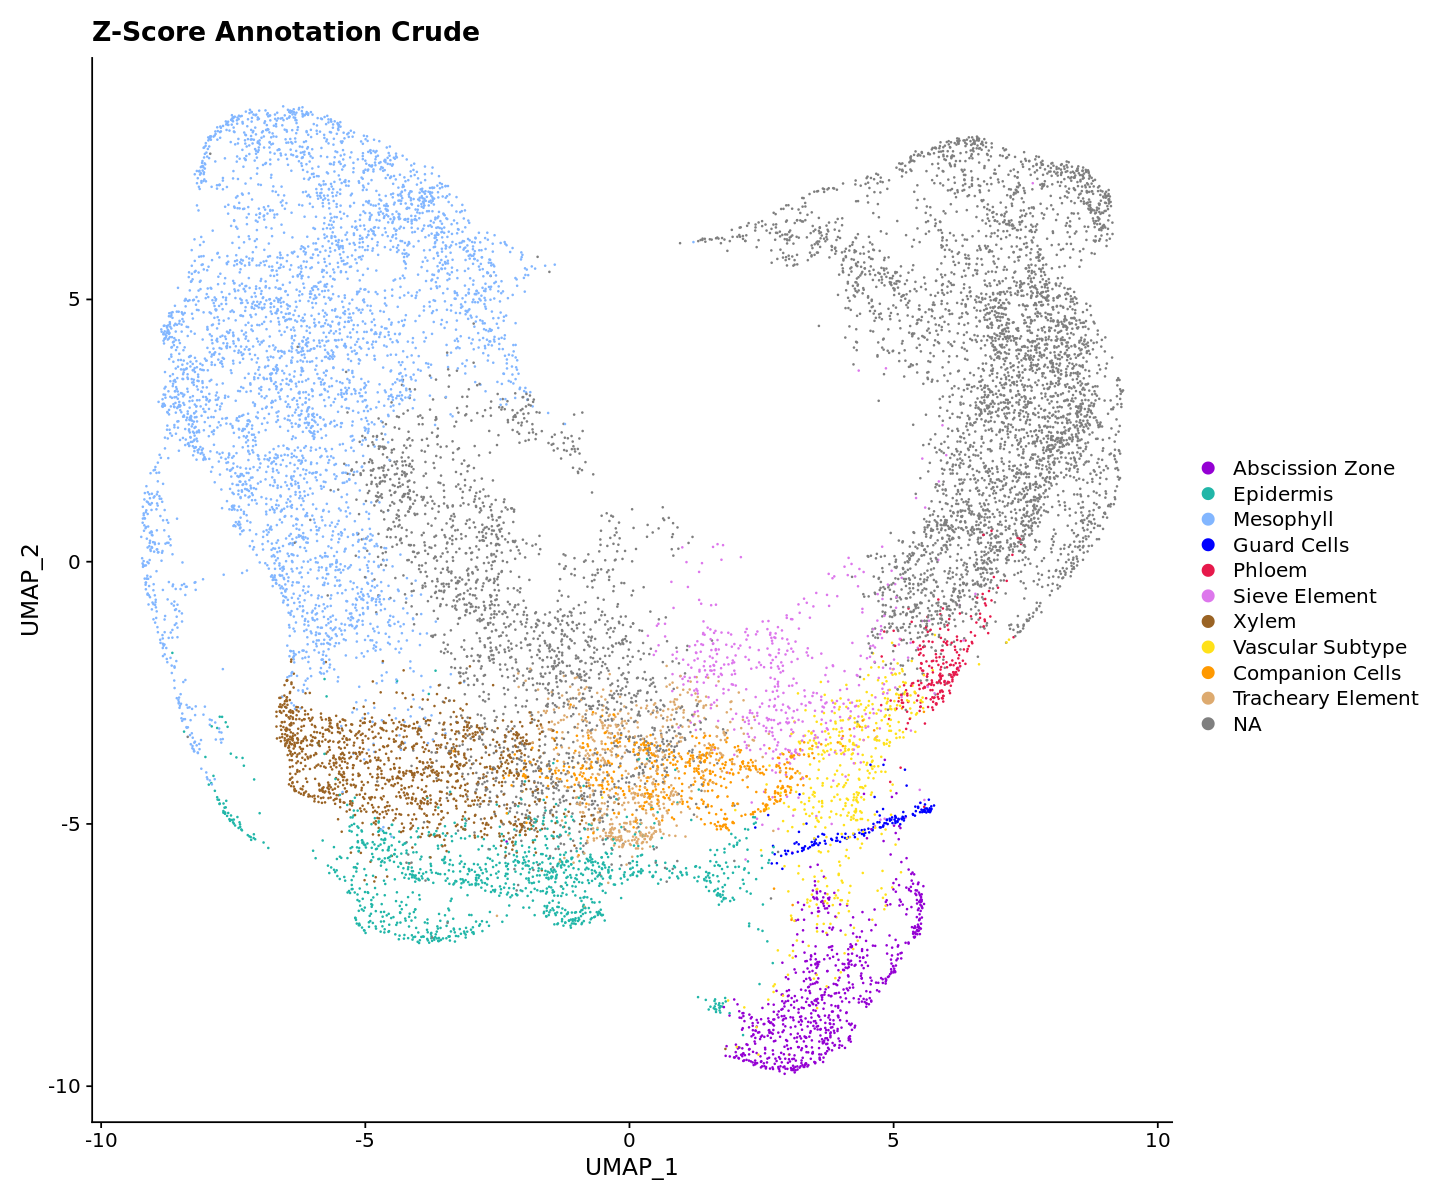

In [30]:
# Plot marker annotation
order <- c("Abscission Zone", "Base of Sepals/Petals","Columella", "Lateral Root Cap", "Atrichoblast", "Epidermis", "Mesophyll", "Guard Cells", "Phloem","Sieve Element", "Xylem", "Vascular Subtype","Companion Cells","Phloem Pole Pericycle", "Protoxylem", "Tracheary Element", "Unknown")
palette <- c("#9400d3", "#DCD0FF","#5ab953", "#bfef45", "#008080", "#21B6A8", "#82b6ff", "#0000FF","#e6194b", "#dd77ec", "#9a6324", "#ffe119", "#ff9900", "#ffd4e3", "#9a6324", "#ddaa6f", "#EEEEEE")
seu_intd_wt$score.crude.anno <- factor(seu_intd_wt$score.crude.anno , levels = order[sort(match(unique(seu_intd_wt$score.crude.anno),order))]) 
color <- palette[sort(match(unique(seu_intd_wt$score.crude.anno),order))]
options(repr.plot.width=12, repr.plot.height=10)
DimPlot(seu_intd_wt, reduction = "umap", group.by = "score.crude.anno", cols = color)+ggtitle("Z-Score Annotation Crude")

In [31]:
# Find clusters, here we choose Leiden clustering algorithm with resolution 0.5. Parameter "algorithm": 1 = original Louvain algorithm; 2 = Louvain algorithm with multilevel refinement; 3 = SLM algorithm; 4 = Leiden algorithm
DefaultAssay(seu_intd_wt) <- "integrated"
suppressMessages(suppressWarnings(
  seu_intd_wt <- FindClusters(seu_intd_wt, resolution = 200, algorithm = 3)
))

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 16169
Number of edges: 506288

Running smart local moving algorithm...
Maximum modularity in 10 random starts: 0.1802
Number of communities: 1149
Elapsed time: 7 seconds


In [32]:
anno <- seu_intd_wt$seurat_clusters
for (i in unique(seu_intd_wt$seurat_clusters)){
    if (max(apply(msc[which(seu_intd_wt$seurat_clusters==i),],2,mean))>0){
        ct <- names(which.max(apply(msc[which(seu_intd_wt$seurat_clusters==i),],2,mean)))
    } else {
        ct <- "NA"
    }
        anno <- gsub(paste0("^",i,"$"), ct, anno, ignore.case = FALSE, perl = FALSE,fixed = FALSE, useBytes = FALSE)
}

seu_intd_wt$score.anno <- anno
# Plot marker annotation
order <- c("Abscission Zone", "Base of Sepals/Petals","Columella", "Lateral Root Cap", "Atrichoblast", "Epidermis", "Mesophyll", "Guard Cells", "Phloem","Sieve Element", "Xylem", "Vascular Subtype","Companion Cells","Phloem Pole Pericycle", "Protoxylem", "Tracheary Element", "Unknown")
palette <- c("#9400d3", "#DCD0FF","#5ab953", "#bfef45", "#008080", "#21B6A8", "#82b6ff", "#0000FF","#e6194b", "#dd77ec", "#9a6324", "#ffe119", "#ff9900", "#ffd4e3", "#9a6324", "#ddaa6f", "#EEEEEE")

seu_intd_wt$score.anno <- factor(seu_intd_wt$score.anno , levels = order[sort(match(unique(seu_intd_wt$score.anno),order))]) 
#color <- palette[sort(match(unique(seu_intd_wt$score.anno),order))]
#options(repr.plot.width=12, repr.plot.height=10)
#DimPlot(seu_intd_wt, reduction = "umap", group.by = "score.anno", cols = color)+ggtitle("Z-Score Annotation")

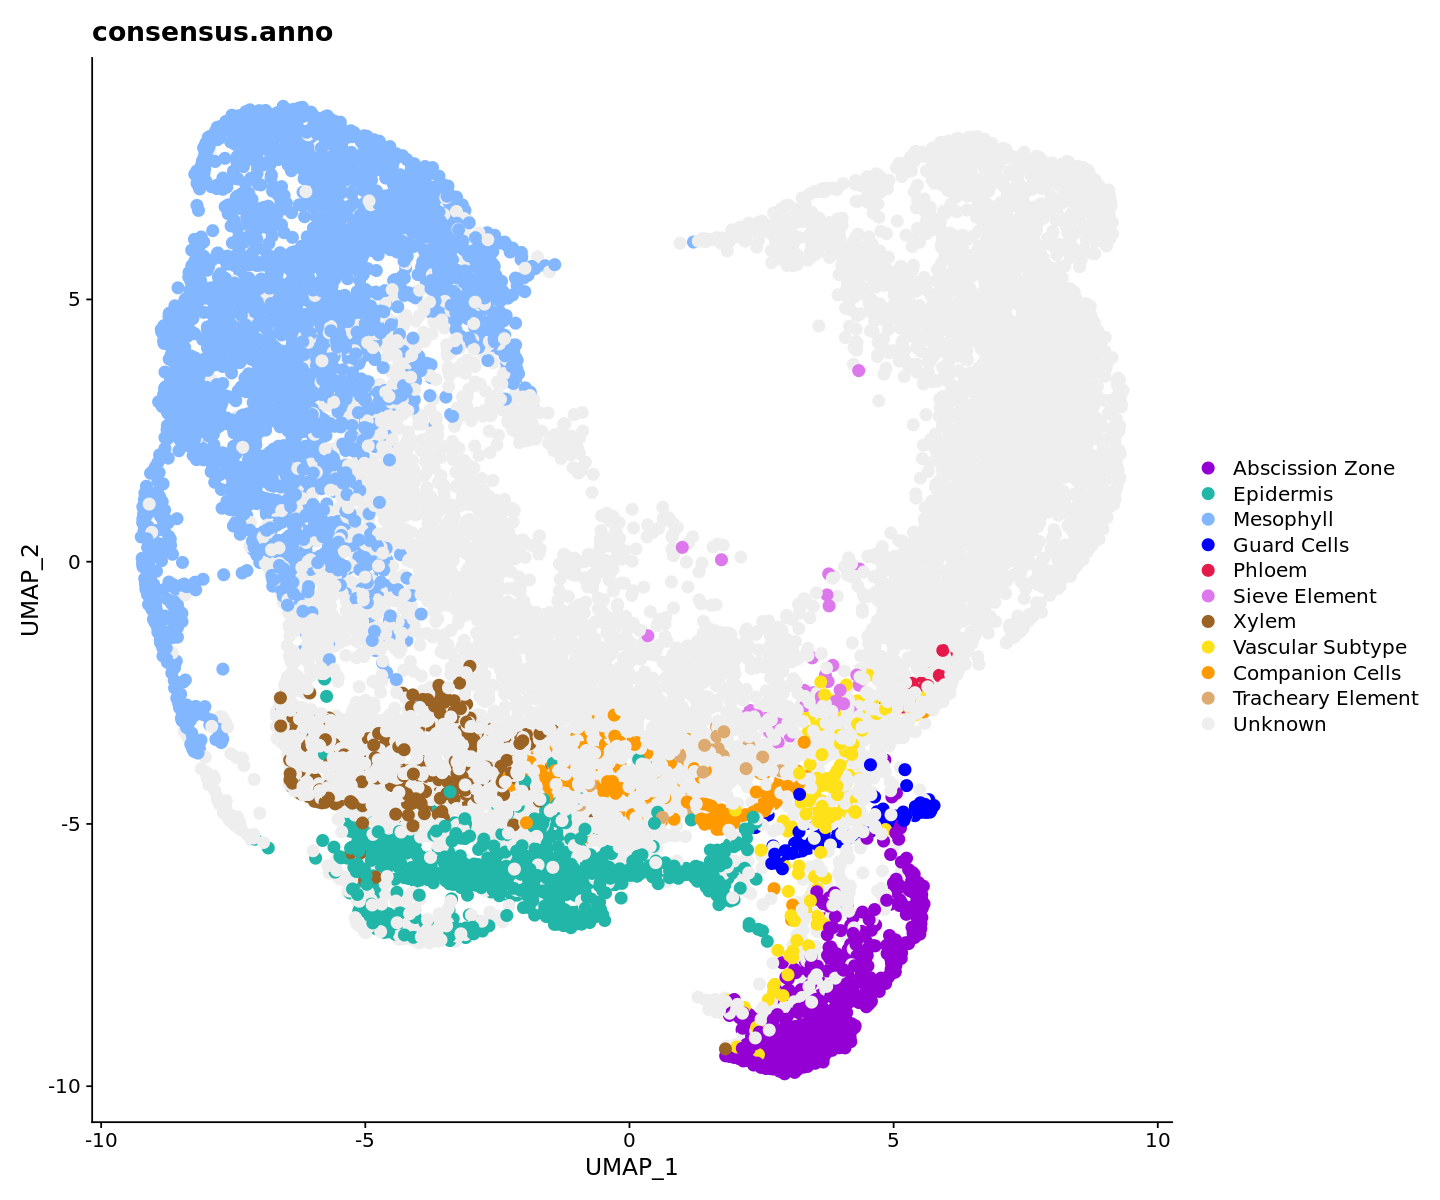

In [33]:
#Consensus Annotation
dat <- data.frame(seu_intd_wt$score.anno, seu_intd_wt$score.crude.anno)
seu_intd_wt$consensus.anno <- apply(dat,1,function(x){if (is.na(x[1])){"Unknown"} else if (is.na(x[2])){"Unknown"} else if (x[1]==x[2]){x[1]} else {"Unknown"}})
#seu_intd_wt$consensus.anno <- apply(dat,1,function(x){if(x[1]==x[2]){x[1]}else if(x[1]=="Trichoblast" & x[2]=="Atrichoblast"){"Trichoblast"}
#    else if(x[1]=="Late Metaxylem" & x[2]=="Phloem"){"Late Metaxylem"}else if(x[1]=="Cortex" & x[2]=="Sclerenchyma"){"Cortex"}
#        else if(x[1]=="Exodermis" & x[2]=="Sclerenchyma"){"Exodermis"}else if(x[1]=="Exodermis" & x[2]=="Endodermis"){"Exodermis"}
#            else if(x[1]=="Cortex" & x[2]=="Endodermis"){"Cortex"}else if(x[1]=="Pericycle" & x[2]=="Endodermis"){"Pericycle"}else if(x[1]=="Phloem" & x[2]=="Endodermis"){"Phloem"}
#                    else if(x[1]=="Late Metaxylem" & x[2]=="Endodermis"){"Late Metaxylem"}else if(x[3]=="Maturation1"|x[3]=="Maturation2"){x[2]}else {"Unknown"}})
order <- c("Abscission Zone", "Base of Sepals/Petals","Columella", "Lateral Root Cap", "Atrichoblast", "Epidermis", "Mesophyll", "Guard Cells", "Phloem","Sieve Element", "Xylem", "Vascular Subtype","Companion Cells","Phloem Pole Pericycle", "Protoxylem", "Tracheary Element", "Unknown")
palette <- c("#9400d3", "#DCD0FF","#5ab953", "#bfef45", "#008080", "#21B6A8", "#82b6ff", "#0000FF","#e6194b", "#dd77ec", "#9a6324", "#ffe119", "#ff9900", "#ffd4e3", "#9a6324", "#ddaa6f", "#EEEEEE")
seu_intd_wt$consensus.anno <- factor(seu_intd_wt$consensus.anno , levels = order[sort(match(unique(seu_intd_wt$consensus.anno),order))]) 
color <- palette[sort(match(unique(seu_intd_wt$consensus.anno),order))]
options(repr.plot.width=12, repr.plot.height=10)
DimPlot(seu_intd_wt, reduction = "umap", group.by = "consensus.anno", pt.size = 3, cols = color)+ggtitle("consensus.anno")

seu_intd_wt$celltype.consensus.anno <- seu_intd_wt$consensus.anno

In [36]:
color <- palette[sort(match( c("Mesophyll", "Phloem", "Xylem", "Guard Cells", "Companion Cells", "Epidermis", "Abscission Zone", "Unknown"), order))]
seu_intd_wt@meta.data[seu_intd_wt@meta.data$consensus.anno == "Tracheary Element",]$consensus.anno = "Unknown"
seu_intd_wt@meta.data[seu_intd_wt@meta.data$consensus.anno == "Sieve Element",]$consensus.anno = "Unknown"
seu_intd_wt@meta.data[seu_intd_wt@meta.data$consensus.anno == "Vascular Subtype",]$consensus.anno = "Unknown"


ERROR: Error in `$<-.data.frame`(`*tmp*`, consensus.anno, value = "Unknown"): replacement has 1 row, data has 0


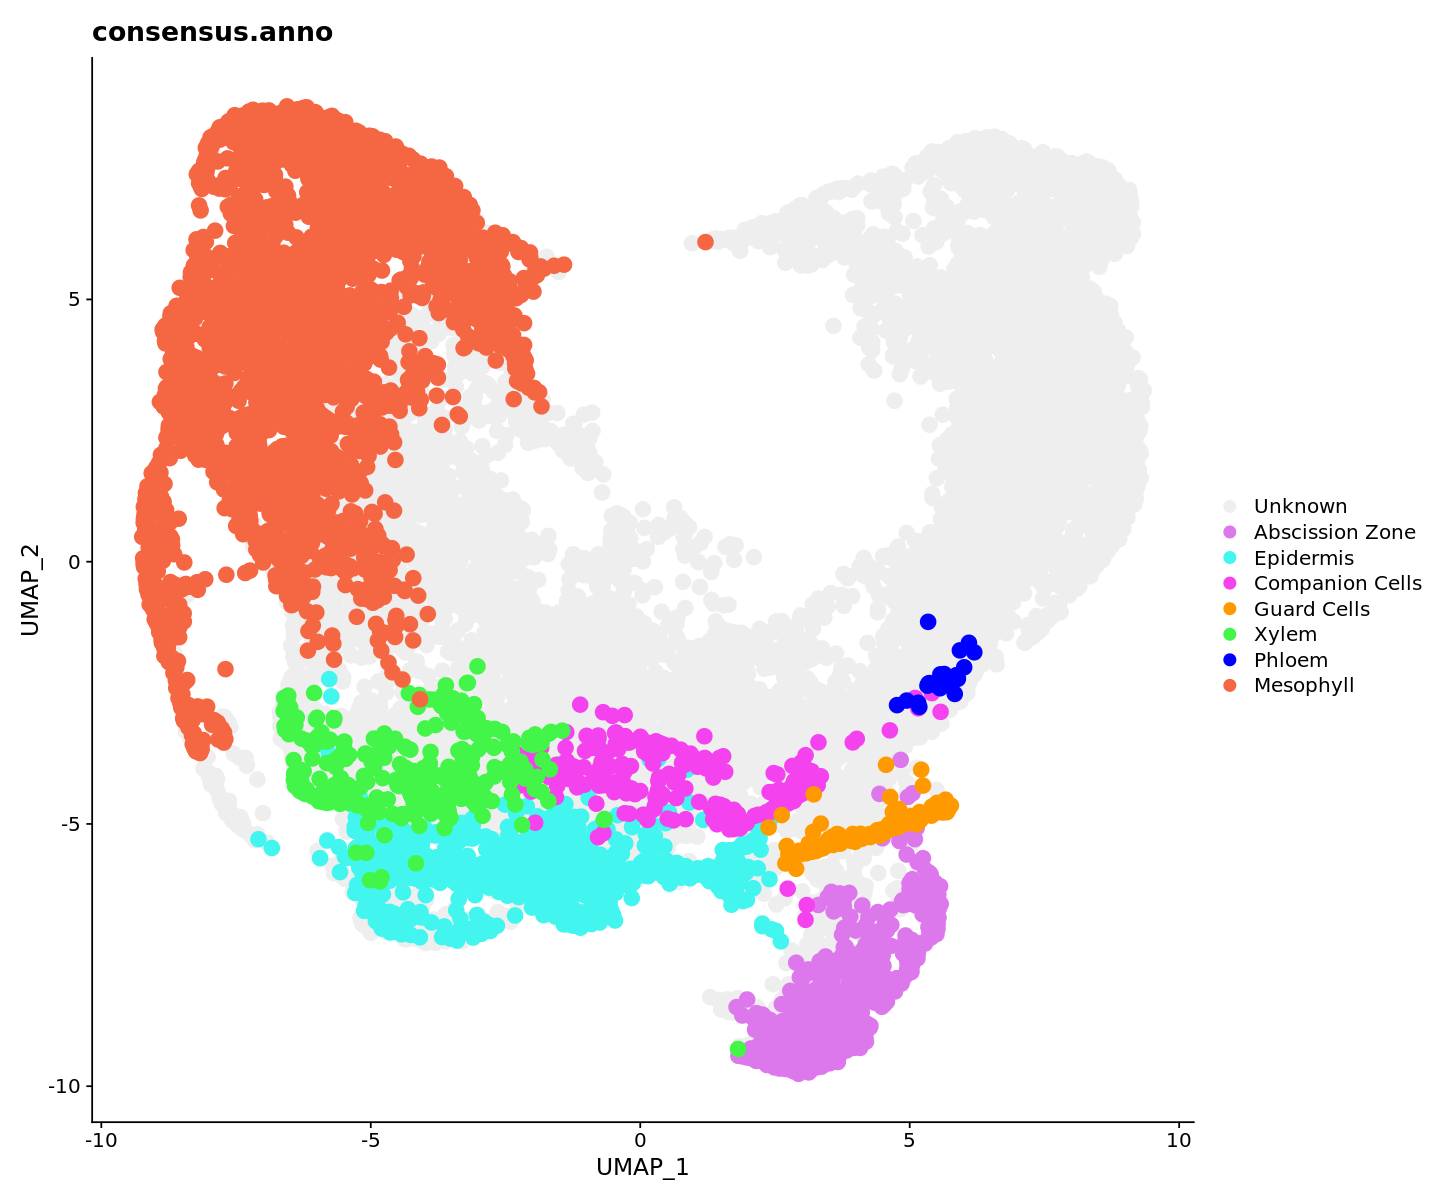

In [39]:
#c("#9400d3", ,"#5ab953", , , "#21B6A8", "#0000FF",, "#dd77ec", "#9a6324", "#ffe119", "#ff9900", "#ffd4e3", "#9a6324", "#ddaa6f", "#EEEEEE")

palette <- c("#EEEEEE", "#dd77ec", "#42f5ef", "#f542ef", "#ff9900", "#42f548", "#0000FF", "#f56642")
plot = DimPlot(seu_intd_wt, reduction = "umap", group.by = "consensus.anno", order = c("Mesophyll", "Phloem", "Xylem", "Guard Cells", "Companion Cells", "Epidermis", "Abscission Zone", "Unknown"), pt.size = 4, cols =palette)+ggtitle("consensus.anno")
ggsave(file=paste0("/home/robotmessenger810/sc_analysis/data/for_figures/gene_plots/figure_2_pngs/celltype_plots/celltype_UMAP.png"), plot=plot, width=10, height=10)
print(plot)

In [40]:
head(seu_intd_wt@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,nCount_spliced,nFeature_spliced,nCount_unspliced,nFeature_unspliced,percent.mito,percent.cp,geno,⋯,seurat_clusters,integrated_snn_res.2,score.crude.anno,integrated_snn_res.200,score.anno,consensus.anno,celltype.consensus.anno,final.anno.P,final.anno.cor.P,final.anno.pvalue.P
,<chr>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<chr>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<fct>,<fct>,<dbl>,<dbl>
AAACCCAAGCCGATCC_1,sc_26_combined,9652,2686,8564,2546,1088,637,0.5387484,8.1019478,WT,⋯,9,9,NA,9,Mesophyll,Unknown,Unknown,Phloem,0.1891524,7.307155e-03
AAACCCAAGTCGGGAT_1,sc_26_combined,6626,1907,5956,1806,670,396,1.2073649,10.5040749,WT,⋯,353,3,NA,353,NA,Unknown,Unknown,Phloem,0.3569749,2.117457e-07
AAACCCAAGTTATGGA_1,sc_26_combined,8824,3110,7828,2905,996,670,1.8812330,2.2892112,WT,⋯,595,13,Xylem,595,Phloem,Unknown,Unknown,Companion Cells,0.1569453,2.645937e-02
AAACCCAAGTTGGAGC_1,sc_26_combined,7051,2636,6131,2485,920,565,1.4466033,8.3392427,WT,⋯,729,8,Mesophyll,729,Mesophyll,Mesophyll,Mesophyll,Mesophyll,0.3075722,9.408749e-06
AAACCCACATCCGTGG_1,sc_26_combined,8192,2938,7334,2772,858,587,1.3183594,0.3540039,WT,⋯,378,16,Abscission Zone,378,Abscission Zone,Abscission Zone,Abscission Zone,Abscission Zone,0.8606361,6.093006e-60
AAACCCAGTAAGTCAA_1,sc_26_combined,4810,1658,4314,1559,496,323,0.7068607,7.1725572,WT,⋯,755,1,NA,755,NA,Unknown,Unknown,Guard Cells,0.2351941,8.009970e-04



Abscission Zone Companion Cells       Epidermis     Guard Cells       Mesophyll 
            661             276             905             149            3513 
         Phloem           Xylem 
             25             324 

[1] 7

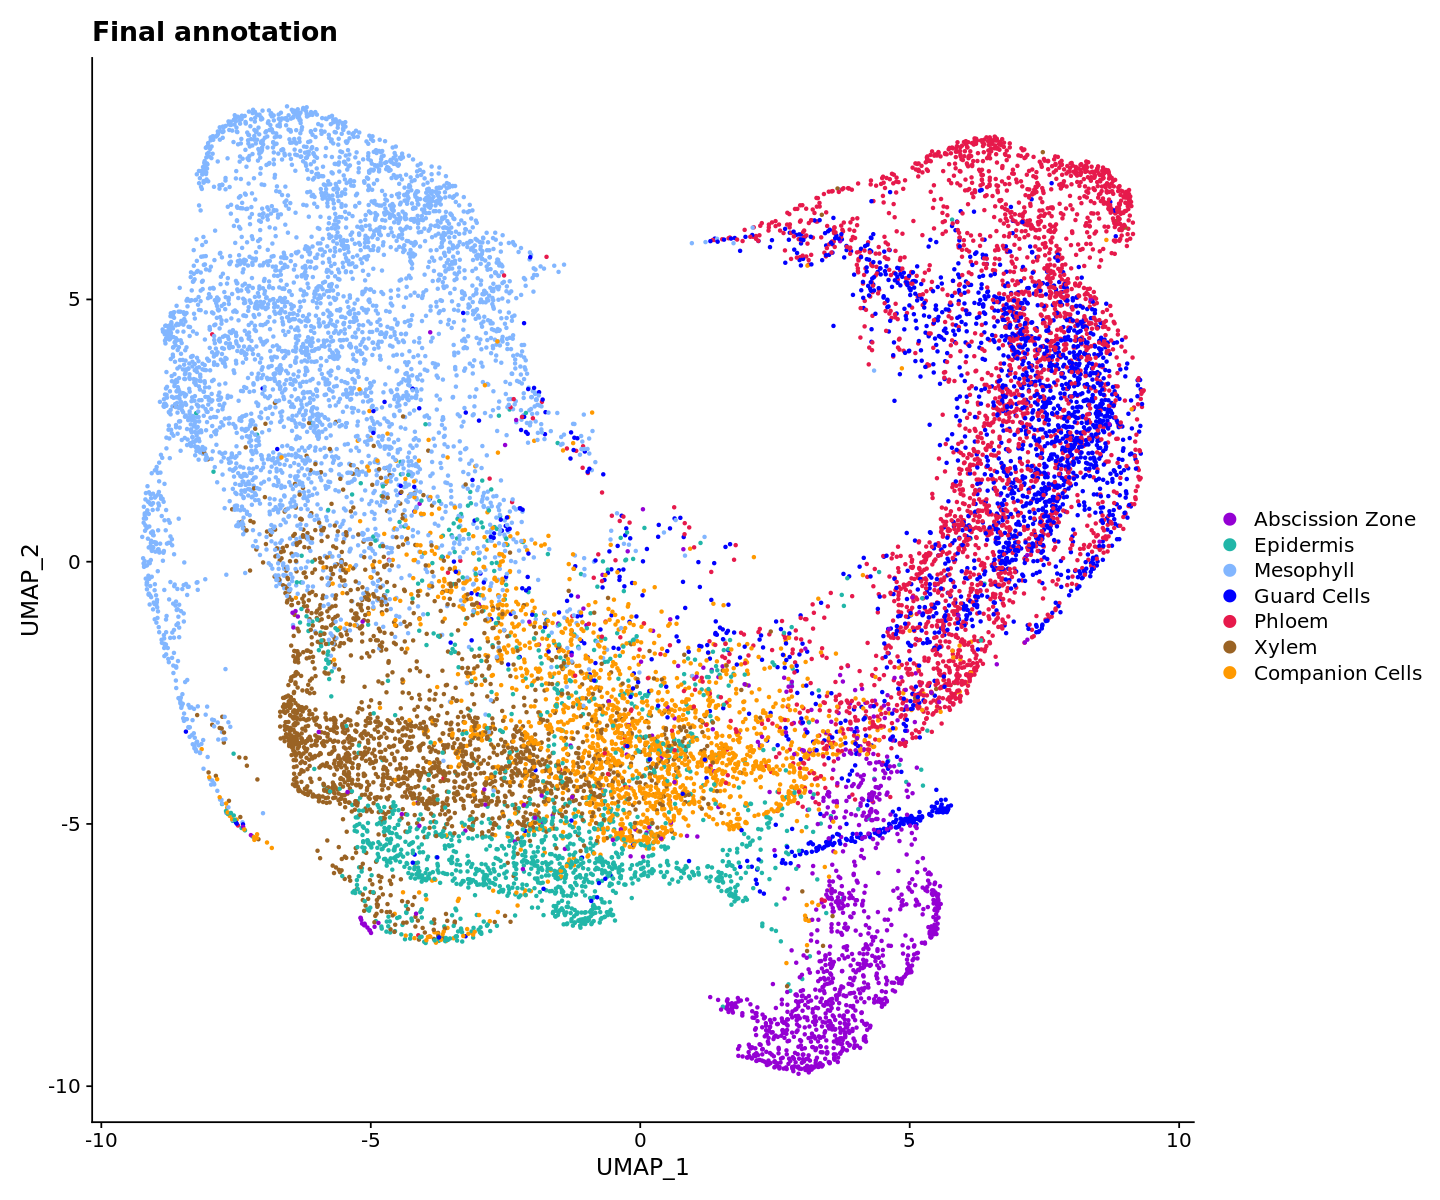

In [38]:
seu_intd_wt$consensus.anno <- as.character(seu_intd_wt$consensus.anno)
table(seu_intd_wt$consensus.anno[which(seu_intd_wt$consensus.anno!="Unknown")])
length(sort(table(seu_intd_wt$consensus.anno[which(seu_intd_wt$consensus.anno!="Unknown")])))

nnc <- length(sort(table(seu_intd_wt$consensus.anno[which(seu_intd_wt$consensus.anno!="Unknown")])))
# Extract integrated (batch-corrected) expression matrix
afm <- seu_intd_wt@assays$integrated@data

# Pool (average) expression values of each grouping
new_ref <- matrix(nrow=nrow(afm), ncol = 0)
for (i in 1:nnc) {
m <- afm[,which(seu_intd_wt$consensus.anno==as.character(unique(seu_intd_wt$consensus.anno[which(seu_intd_wt$consensus.anno!="Unknown")]))[i])]
new_ref <- cbind(new_ref, rowSums(m)/ncol(m))
}
colnames(new_ref) <- as.character(unique(seu_intd_wt$consensus.anno[which(seu_intd_wt$consensus.anno!="Unknown")]))
gene.var <- apply(new_ref,1,var)

# Select top 200 highly variable genes 
new_ref_sub <- new_ref[names(sort(gene.var,decreasing = TRUE)[1:200]),]

# Merge newly-built reference with atlas

merge.rownames <- function (x,y){
  dat <- merge(x = x, y = y, by = "row.names")
  rownames(dat) <- dat$Row.names
  dat <- dat[,-1]
  return(dat)
}

nr <- Reduce(merge.rownames, list(new_ref_sub,afm)) 
nr <- as.matrix(nr)

# Correlation-based annotation using newly-built references
nr_label=colnames(new_ref)
nr_stat <- suppressWarnings(sapply((nnc+1):ncol(nr), function(i) sapply(1:nnc, function(j) cor.test(nr[,i],nr[,j],method = "pearson")[c(3,4)])))
nr_cor <- nr_stat[seq(2,nrow(nr_stat),2),]
nr_pvalue <- nr_stat[seq(1,nrow(nr_stat)-1,2),]                                                                                                        
nr_max <- sapply(1:(ncol(nr)-nnc), function(i) max(as.numeric(nr_cor[,i])))
nr_ident <- sapply(1:(ncol(nr)-nnc), function(i) nr_label[which(as.numeric(nr_cor[,i])==max(as.numeric(nr_cor[,i])))])
nr_maxp <- sapply(1:(ncol(nr)-nnc), function(i) as.numeric(nr_pvalue[,i])[which(as.numeric(nr_cor[,i])==max(as.numeric(nr_cor[,i])))])                     
names(nr_max) <- nr_ident
seu_intd_wt$final.anno.P <- as.character(nr_ident)
seu_intd_wt$final.anno.cor.P <- as.numeric(nr_max)
seu_intd_wt$final.anno.pvalue.P <- as.numeric(nr_maxp)
# Plot marker annotation
order <- c("Abscission Zone", "Base of Sepals/Petals","Columella", "Lateral Root Cap", "Atrichoblast", "Epidermis", "Mesophyll", "Guard Cells", "Phloem","Sieve Element", "Xylem", "Vascular Subtype","Companion Cells","Phloem Pole Pericycle", "Protoxylem", "Tracheary Element", "Unknown")
palette <- c("#9400d3", "#DCD0FF","#5ab953", "#bfef45", "#008080", "#21B6A8", "#82b6ff", "#0000FF","#e6194b", "#dd77ec", "#9a6324", "#ffe119", "#ff9900", "#ffd4e3", "#9a6324", "#ddaa6f", "#EEEEEE")
seu_intd_wt$final.anno.P <- factor(seu_intd_wt$final.anno.P , levels = order[sort(match(unique(seu_intd_wt$final.anno.P),order))]) 
color <- palette[sort(match(unique(seu_intd_wt$final.anno.P),order))]
options(repr.plot.width=12, repr.plot.height=10)
DimPlot(seu_intd_wt, reduction = "umap", group.by = "final.anno.P", cols = color, pt.size=0.6)+ggtitle("Final annotation")

In [ ]:
trava_genes = read.csv("../data/bulk_data/trava_DE_genes.csv", header = F)
colnames(trava_genes) = c("Locus", "Celltype")

In [ ]:
#known.good.markers <- rbind(known.good.markers[,c(2,3)], trava_genes)
#known.good.markers = known.good.markers[-which(known.good.markers$Locus=="AT1G77525"),] 
known.good.markers = trava_genes[-which(trava_genes$Locus=="AT1G77525"),]

In [ ]:
msc <- c()
for (i in as.character(unique(known.good.markers$Celltype))){
    print(i)
    if (length(known.good.markers[which(known.good.markers$Celltype== i),]$Locus)>1){
    msc <- cbind(msc, as.numeric(apply(apply(seu_intd_wt@assays$SCT@data[known.good.markers[which(known.good.markers$Celltype == i),]$Locus,], 1, zscore), 1, mean)))       
    } else {
    msc <- cbind(msc, as.numeric(zscore(seu_intd_wt@assays$SCT@data[known.good.markers[which(known.good.markers$Celltype== i),]$Locus,])))      
    }

}
colnames(msc) <- as.character(unique(known.good.markers$Celltype))
rownames(msc) <- colnames(seu_intd_wt)

In [ ]:
# Crude
# Find clusters, here we choose Leiden clustering algorithm with resolution 0.5. Parameter "algorithm": 1 = original Louvain algorithm; 2 = Louvain algorithm with multilevel refinement; 3 = SLM algorithm; 4 = Leiden algorithm
DefaultAssay(seu_intd_wt) <- "integrated"
suppressMessages(suppressWarnings(
  seu_intd_wt <- FindClusters(seu_intd_wt, resolution = 2, algorithm = 3)
))

In [ ]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(seu_intd_wt, reduction = "umap", label=TRUE)+NoLegend()

anno <- seu_intd_wt$seurat_clusters
for (i in unique(seu_intd_wt$seurat_clusters)){
    if (max(apply(msc[which(seu_intd_wt$seurat_clusters==i),],2,mean))>0){
        ct <- names(which.max(apply(msc[which(seu_intd_wt$seurat_clusters==i),],2,mean)))
    } else {
        ct <- "NA"
    }
        anno <- gsub(paste0("^",i,"$"), ct, anno, ignore.case = FALSE, perl = FALSE,fixed = FALSE, useBytes = FALSE)
}

In [ ]:
seu_intd_wt$score.crude.anno <- anno
# Plot marker annotation
order <- c("Abscission Zone", "Base of Sepals/Petals","Columella", "Lateral Root Cap", "Atrichoblast", "Silique", "Petal", "Sepal", "Carpel","Sieve Element", "Xylem", "Vascular Subtype","Filament","Phloem Pole Pericycle", "Protoxylem", "Tracheary Element", "Unknown")
palette <- c("#9400d3", "#DCD0FF","#5ab953", "#bfef45", "#008080", "#21B6A8", "#82b6ff", "#0000FF","#e6194b", "#dd77ec", "#9a6324", "#ffe119", "#ff9900", "#ffd4e3", "#9a6324", "#ddaa6f", "#EEEEEE")
seu_intd_wt$score.crude.anno <- factor(seu_intd_wt$score.crude.anno , levels = order[sort(match(unique(seu_intd_wt$score.crude.anno),order))]) 
color <- palette[sort(match(unique(seu_intd_wt$score.crude.anno),order))]
options(repr.plot.width=12, repr.plot.height=10)
DimPlot(seu_intd_wt, reduction = "umap", group.by = "score.crude.anno", cols = color)+ggtitle("Z-Score Annotation Crude")

In [ ]:
# Find clusters, here we choose Leiden clustering algorithm with resolution 0.5. Parameter "algorithm": 1 = original Louvain algorithm; 2 = Louvain algorithm with multilevel refinement; 3 = SLM algorithm; 4 = Leiden algorithm
DefaultAssay(seu_intd_wt) <- "integrated"
suppressMessages(suppressWarnings(
  seu_intd_wt <- FindClusters(seu_intd_wt, resolution = 200, algorithm = 3)
))

In [ ]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(seu_intd_wt, reduction = "umap")+NoLegend()

In [ ]:
anno <- seu_intd_wt$seurat_clusters
for (i in unique(seu_intd_wt$seurat_clusters)){
    if (max(apply(msc[which(seu_intd_wt$seurat_clusters==i),],2,mean))>0){
        ct <- names(which.max(apply(msc[which(seu_intd_wt$seurat_clusters==i),],2,mean)))
    } else {
        ct <- "NA"
    }
        anno <- gsub(paste0("^",i,"$"), ct, anno, ignore.case = FALSE, perl = FALSE,fixed = FALSE, useBytes = FALSE)
}

In [ ]:
seu_intd_wt$score.anno <- anno
# Plot marker annotation
order <- c("Abscission Zone", "Base of Sepals/Petals","Columella", "Lateral Root Cap", "Atrichoblast", "Silique", "Petal", "Sepal", "Carpel","Sieve Element", "Xylem", "Vascular Subtype","Filament","Phloem Pole Pericycle", "Protoxylem", "Tracheary Element", "Unknown")
palette <- c("#9400d3", "#DCD0FF","#5ab953", "#bfef45", "#008080", "#21B6A8", "#82b6ff", "#0000FF","#e6194b", "#dd77ec", "#9a6324", "#ffe119", "#ff9900", "#ffd4e3", "#9a6324", "#ddaa6f", "#EEEEEE")
seu_intd_wt$score.anno <- factor(seu_intd_wt$score.anno , levels = order[sort(match(unique(seu_intd_wt$score.anno),order))]) 
color <- palette[sort(match(unique(seu_intd_wt$score.anno),order))]
options(repr.plot.width=12, repr.plot.height=10)
DimPlot(seu_intd_wt, reduction = "umap", group.by = "score.anno", cols = color)+ggtitle("Z-Score Annotation")

In [ ]:
dat <- data.frame(seu_intd_wt$score.anno, seu_intd_wt$score.crude.anno)

In [ ]:
seu_intd_wt$consensus.anno <- apply(dat,1,function(x){if (is.na(x[1])){"Unknown"} else if (is.na(x[2])){"Unknown"} else if (x[1]==x[2]){x[1]} else {"Unknown"}})
#seu_intd_wt$consensus.anno <- apply(dat,1,function(x){if(x[1]==x[2]){x[1]}else if(x[1]=="Trichoblast" & x[2]=="Atrichoblast"){"Trichoblast"}
#    else if(x[1]=="Late Metaxylem" & x[2]=="Phloem"){"Late Metaxylem"}else if(x[1]=="Cortex" & x[2]=="Sclerenchyma"){"Cortex"}
#        else if(x[1]=="Exodermis" & x[2]=="Sclerenchyma"){"Exodermis"}else if(x[1]=="Exodermis" & x[2]=="Endodermis"){"Exodermis"}
#            else if(x[1]=="Cortex" & x[2]=="Endodermis"){"Cortex"}else if(x[1]=="Pericycle" & x[2]=="Endodermis"){"Pericycle"}else if(x[1]=="Phloem" & x[2]=="Endodermis"){"Phloem"}
#                    else if(x[1]=="Late Metaxylem" & x[2]=="Endodermis"){"Late Metaxylem"}else if(x[3]=="Maturation1"|x[3]=="Maturation2"){x[2]}else {"Unknown"}})
order <- c("Abscission Zone", "Base of Sepals/Petals","Columella", "Lateral Root Cap", "Atrichoblast", "Silique", "Petal", "Sepal", "Carpel","Sieve Element", "Xylem", "Vascular Subtype","Filament","Phloem Pole Pericycle", "Protoxylem", "Tracheary Element", "Unknown")
palette <- c("#9400d3", "#DCD0FF","#5ab953", "#bfef45", "#008080", "#21B6A8", "#82b6ff", "#0000FF","#e6194b", "#dd77ec", "#9a6324", "#ffe119", "#ff9900", "#ffd4e3", "#9a6324", "#ddaa6f", "#EEEEEE")
seu_intd_wt$consensus.anno <- factor(seu_intd_wt$consensus.anno , levels = order[sort(match(unique(seu_intd_wt$consensus.anno),order))]) 
color <- palette[sort(match(unique(seu_intd_wt$consensus.anno),order))]
options(repr.plot.width=12, repr.plot.height=10)

DimPlot(seu_intd_wt, reduction = "umap", group.by = "consensus.anno", cols = color)+ggtitle("consensus.anno")

In [ ]:
seu_intd_wt$organ.consensus.anno <- seu_intd_wt$consensus.anno
seu_intd_wt$consensus.anno <- as.character(seu_intd_wt$consensus.anno)
table(seu_intd_wt$consensus.anno[which(seu_intd_wt$consensus.anno!="Unknown")])
length(sort(table(seu_intd_wt$consensus.anno[which(seu_intd_wt$consensus.anno!="Unknown")])))


nnc <- length(sort(table(seu_intd_wt$consensus.anno[which(seu_intd_wt$consensus.anno!="Unknown")])))
# Extract integrated (batch-corrected) expression matrix
afm <- seu_intd_wt@assays$integrated@data

# Pool (average) expression values of each grouping
new_ref <- matrix(nrow=nrow(afm), ncol = 0)
for (i in 1:nnc) {
m <- afm[,which(seu_intd_wt$consensus.anno==as.character(unique(seu_intd_wt$consensus.anno[which(seu_intd_wt$consensus.anno!="Unknown")]))[i])]
new_ref <- cbind(new_ref, rowSums(m)/ncol(m))
}
colnames(new_ref) <- as.character(unique(seu_intd_wt$consensus.anno[which(seu_intd_wt$consensus.anno!="Unknown")]))
gene.var <- apply(new_ref,1,var)

# Select top 200 highly variable genes 
new_ref_sub <- new_ref[names(sort(gene.var,decreasing = TRUE)[1:200]),]

# Merge newly-built reference with atlas

merge.rownames <- function (x,y){
  dat <- merge(x = x, y = y, by = "row.names")
  rownames(dat) <- dat$Row.names
  dat <- dat[,-1]
  return(dat)
}

In [ ]:
nr <- Reduce(merge.rownames, list(new_ref_sub,afm)) 
nr <- as.matrix(nr)
head(nr)
# Correlation-based annotation using newly-built references
nr_label=colnames(new_ref)
nr_stat <- suppressWarnings(sapply((nnc+1):ncol(nr), function(i) sapply(1:nnc, function(j) cor.test(nr[,i],nr[,j],method = "pearson")[c(3,4)])))
nr_cor <- nr_stat[seq(2,nrow(nr_stat),2),]
nr_pvalue <- nr_stat[seq(1,nrow(nr_stat)-1,2),]                                                                                                        
nr_max <- sapply(1:(ncol(nr)-nnc), function(i) max(as.numeric(nr_cor[,i])))
nr_ident <- sapply(1:(ncol(nr)-nnc), function(i) nr_label[which(as.numeric(nr_cor[,i])==max(as.numeric(nr_cor[,i])))])
nr_maxp <- sapply(1:(ncol(nr)-nnc), function(i) as.numeric(nr_pvalue[,i])[which(as.numeric(nr_cor[,i])==max(as.numeric(nr_cor[,i])))])                     
names(nr_max) <- nr_ident
seu_intd_wt$final.anno.P <- as.character(nr_ident)
seu_intd_wt$final.anno.cor.P <- as.numeric(nr_max)
seu_intd_wt$final.anno.pvalue.P <- as.numeric(nr_maxp)
# Plot marker annotation
order <- c("Abscission Zone", "Base of Sepals/Petals","Columella", "Lateral Root Cap", "Atrichoblast", "Silique", "Petal", "Sepal", "Carpel","Sieve Element", "Xylem", "Vascular Subtype","Filament","Phloem Pole Pericycle", "Protoxylem", "Tracheary Element", "Unknown")
palette <- c("#9400d3", "#DCD0FF","#5ab953", "#bfef45", "#008080", "#21B6A8", "#82b6ff", "#0000FF","#e6194b", "#dd77ec", "#9a6324", "#ffe119", "#ff9900", "#ffd4e3", "#9a6324", "#ddaa6f", "#EEEEEE")
seu_intd_wt$final.anno.P <- factor(seu_intd_wt$final.anno.P , levels = order[sort(match(unique(seu_intd_wt$final.anno.P),order))]) 
color <- palette[sort(match(unique(seu_intd_wt$final.anno.P),order))]
options(repr.plot.width=12, repr.plot.height=10)
DimPlot(seu_intd_wt, reduction = "umap", group.by = "final.anno.P", cols = color, pt.size=0.6)+ggtitle("Final annotation")

seu_intd_wt$organ.anno <- seu_intd_wt$final.anno.P
seu_intd_wt$organ.anno.cor.P <- seu_intd_wt$final.anno.cor.P
seu_intd_wt$organ.anno.pvalue.P <- seu_intd_wt$final.anno.pvalue.P

In [ ]:
dat <- data.frame(seu_intd_wt$organ.consensus.anno, seu_intd_wt$celltype.consensus.anno)
seu_intd_wt$consensus.anno <- apply(dat,1,function(x){if (x[1]!="Unknown" & x[1]!="Carpel" & x[1]!="Filament" & x[2]=="Unknown"){x[1]} else if (x[1]==x[2]){x[1]} else if (x[2]!="Abscission Zone" & x[2]!="Base of Sepals/Petals") {x[2]} else {"Unknown"}})
#seu_intd_wt$consensus.anno <- apply(dat,1,function(x){if(x[1]==x[2]){x[1]}else if(x[1]=="Trichoblast" & x[2]=="Atrichoblast"){"Trichoblast"}
#    else if(x[1]=="Late Metaxylem" & x[2]=="Phloem"){"Late Metaxylem"}else if(x[1]=="Cortex" & x[2]=="Sclerenchyma"){"Cortex"}
#        else if(x[1]=="Exodermis" & x[2]=="Sclerenchyma"){"Exodermis"}else if(x[1]=="Exodermis" & x[2]=="Endodermis"){"Exodermis"}
#            else if(x[1]=="Cortex" & x[2]=="Endodermis"){"Cortex"}else if(x[1]=="Pericycle" & x[2]=="Endodermis"){"Pericycle"}else if(x[1]=="Phloem" & x[2]=="Endodermis"){"Phloem"}
#                    else if(x[1]=="Late Metaxylem" & x[2]=="Endodermis"){"Late Metaxylem"}else if(x[3]=="Maturation1"|x[3]=="Maturation2"){x[2]}else {"Unknown"}})
# Plot marker annotation
order <- c("Abscission Zone", "Base of Sepals/Petal","Columella", "Sepal", "Petal", "Silique", "Mesophyll", "Guard Cells", "Phloem","Atrichoblast", "Xylem", "Vascular Subtype","Companion Cells","Epidermis", "Carpel", "Filament", "Unknown")
palette <- c("#9400d3", "#DCD0FF","#5ab953", "#bfef45", "#008080", "#21B6A8", "#82b6ff", "#0000FF","#e6194b", "#dd77ec", "#9a6324", "#ffe119", "#ff9900", "#ffd4e3", "#9a6324", "#ddaa6f", "#EEEEEE")
seu_intd_wt$consensus.anno <- factor(seu_intd_wt$consensus.anno , levels = order[sort(match(unique(seu_intd_wt$consensus.anno),order))]) 
color <- palette[sort(match(unique(seu_intd_wt$consensus.anno),order))]
options(repr.plot.width=12, repr.plot.height=10)
DimPlot(seu_intd_wt, reduction = "umap", group.by = "consensus.anno", cols = color)+ggtitle("consensus.anno")

seu_intd_wt$consensus.anno <- as.character(seu_intd_wt$consensus.anno)
table(seu_intd_wt$consensus.anno[which(seu_intd_wt$consensus.anno!="Unknown")])

length(sort(table(seu_intd_wt$consensus.anno[which(seu_intd_wt$consensus.anno!="Unknown")])))

nnc <- length(sort(table(seu_intd_wt$consensus.anno[which(seu_intd_wt$consensus.anno!="Unknown")])))
# Extract integrated (batch-corrected) expression matrix
afm <- seu_intd_wt@assays$integrated@data

# Pool (average) expression values of each grouping
new_ref <- matrix(nrow=nrow(afm), ncol = 0)
for (i in 1:nnc) {
m <- afm[,which(seu_intd_wt$consensus.anno==as.character(unique(seu_intd_wt$consensus.anno[which(seu_intd_wt$consensus.anno!="Unknown")]))[i])]
new_ref <- cbind(new_ref, rowSums(m)/ncol(m))
}
colnames(new_ref) <- as.character(unique(seu_intd_wt$consensus.anno[which(seu_intd_wt$consensus.anno!="Unknown")]))
gene.var <- apply(new_ref,1,var)

# Select top 200 highly variable genes 
new_ref_sub <- new_ref[names(sort(gene.var,decreasing = TRUE)[1:200]),]

# Merge newly-built reference with atlas

In [ ]:
merge.rownames <- function (x,y){
  dat <- merge(x = x, y = y, by = "row.names")
  rownames(dat) <- dat$Row.names
  dat <- dat[,-1]
  return(dat)
}

nr <- Reduce(merge.rownames, list(new_ref_sub,afm)) 
nr <- as.matrix(nr)
head(nr)


# Correlation-based annotation using newly-built references
nr_label=colnames(new_ref)
nr_stat <- suppressWarnings(sapply((nnc+1):ncol(nr), function(i) sapply(1:nnc, function(j) cor.test(nr[,i],nr[,j],method = "pearson")[c(3,4)])))
nr_cor <- nr_stat[seq(2,nrow(nr_stat),2),]
nr_pvalue <- nr_stat[seq(1,nrow(nr_stat)-1,2),]                                                                                                        
nr_max <- sapply(1:(ncol(nr)-nnc), function(i) max(as.numeric(nr_cor[,i])))
nr_ident <- sapply(1:(ncol(nr)-nnc), function(i) nr_label[which(as.numeric(nr_cor[,i])==max(as.numeric(nr_cor[,i])))])
nr_maxp <- sapply(1:(ncol(nr)-nnc), function(i) as.numeric(nr_pvalue[,i])[which(as.numeric(nr_cor[,i])==max(as.numeric(nr_cor[,i])))])                     
names(nr_max) <- nr_ident
seu_intd_wt$final.anno.P <- as.character(nr_ident)
seu_intd_wt$final.anno.cor.P <- as.numeric(nr_max)
seu_intd_wt$final.anno.pvalue.P <- as.numeric(nr_maxp)
# Plot marker annotation
order <- c("Abscission Zone", "Base of Sepals/Petal","Columella", "Sepal", "Petal", "Silique", "Mesophyll", "Guard Cells", "Phloem","Atrichoblast", "Xylem", "Vascular Subtype","Companion Cells","Epidermis", "Carpel", "Filament", "Unknown")
palette <- c("#9400d3", "#DCD0FF","#5ab953", "#bfef45", "#008080", "#21B6A8", "#82b6ff", "#0000FF","#e6194b", "#dd77ec", "#9a6324", "#ffe119", "#ff9900", "#ffd4e3", "#9a6324", "#ddaa6f", "#EEEEEE")
seu_intd_wt$final.anno.P <- factor(seu_intd_wt$final.anno.P , levels = order[sort(match(unique(seu_intd_wt$final.anno.P),order))]) 
color <- palette[sort(match(unique(seu_intd_wt$final.anno.P),order))]
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(seu_intd_wt, reduction = "umap", group.by = "final.anno.P", cols = color, pt.size=0.6)+ggtitle("Final annotation")

In [ ]:
saveRDS(seu_intd_wt, file = "../data/seurat_objects/CW_annotation.RDS")